## Project overview

Earlier, the data team observed that if a user is verified, they are much more likely to post opinions. Now, the data team has decided to explore how to predict verified status to help them understand how video characteristics relate to verified users. Therefore, I have been asked to conduct a logistic regression using verified status as the outcome variable. The results may be used to inform the final model related to predicting whether a video is a claim vs an opinion.

The general steps I will use:

1. EDA & Checking Model Assumptions
2. Model building and evaluation 
3. Interpreting Model Results



In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [3]:
#Load dataset (tiktok_dataset.csv)
data = pd.read_csv(r"C:\Users\LENOVO\OneDrive\Desktop\Data analytics\Portfolio\Full_cycle projects\TikTok classification machine learning\Dataset\tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


**General data inspection**

In [4]:
#See total rows and columns 
data.shape

(19382, 12)

In [6]:
#See data types 
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

In [7]:
#See nulls 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [8]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [9]:
# Check for duplicates
data.duplicated().sum()

0

### Check model assumptions

**No extreme outliers assumption**

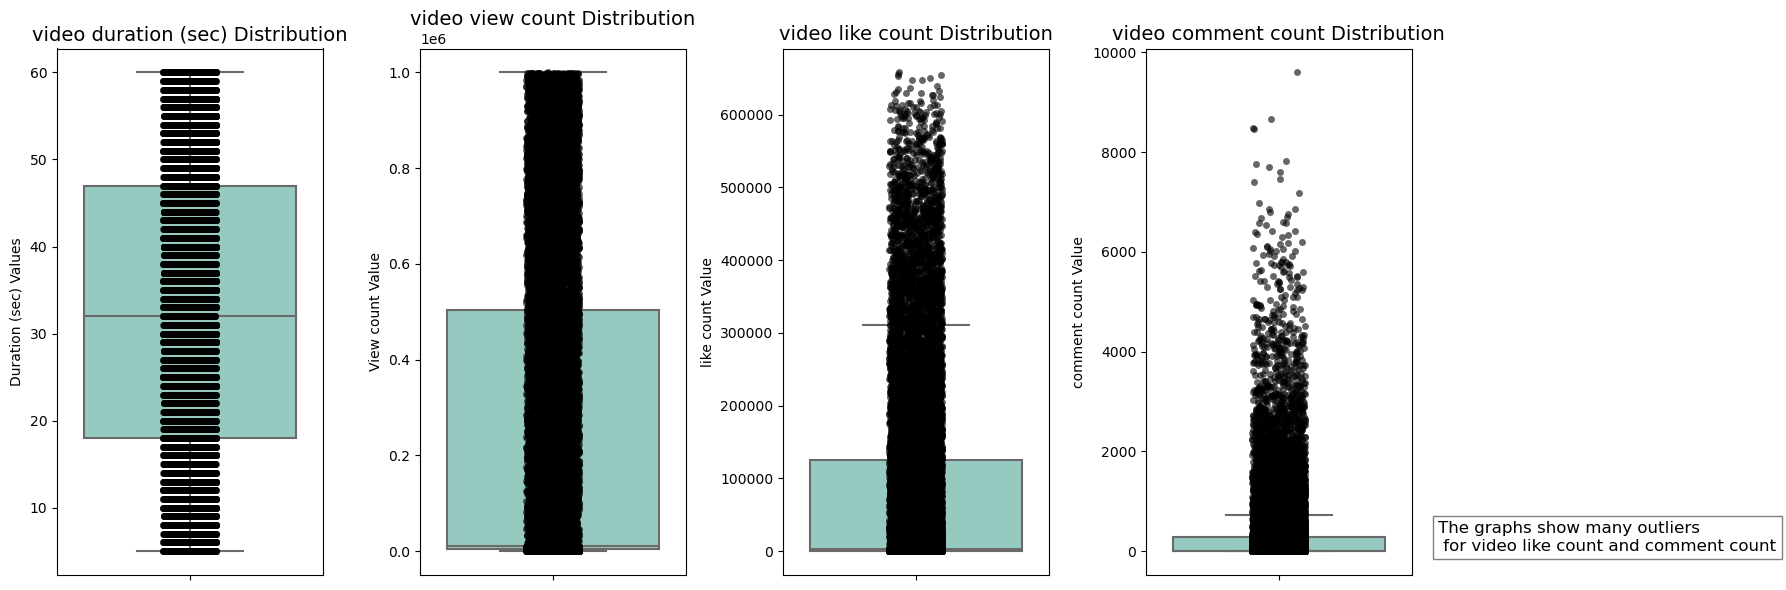

In [13]:
# Create a figure with 4 subplots boxplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=False)

# video_duration_sec box
sns.boxplot(ax=axes[0], y='video_duration_sec', data=data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[0], y='video_duration_sec', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[0].set_title('video duration (sec) Distribution', fontsize=14)
axes[0].set_ylabel('Duration (sec) Values')

#Add description text
plt.text(0.6, 8, 'The graphs show many outliers\n for video like count and comment count', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# video_view_count Boxplot 
sns.boxplot(ax=axes[1], y='video_view_count', data= data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[1], y='video_view_count', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[1].set_title('video view count Distribution', fontsize=14)
axes[1].set_ylabel('View count Value')

# video_like_count Boxplot 
sns.boxplot(ax=axes[2], y='video_like_count', data= data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[2], y='video_like_count', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[2].set_title('video like count Distribution', fontsize=14)
axes[2].set_ylabel('like count Value')

# video_comment_count Boxplot 
sns.boxplot(ax=axes[3], y='video_comment_count', data= data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[3], y='video_comment_count', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[3].set_title('video comment count Distribution', fontsize=14)
axes[3].set_ylabel('comment count Value')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [14]:
# Check for and handle outliers. I replaced values > upper limit by the upper limit value

percentile25 = data["video_like_count"].quantile(0.25)
percentile75 = data["video_like_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_like_count"] > upper_limit, "video_like_count"] = upper_limit

In [23]:
# Check for and handle outliers for comment count

percentile25 = data["video_comment_count"].quantile(0.25)
percentile75 = data["video_comment_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_comment_count"] > upper_limit, "video_comment_count"] = upper_limit

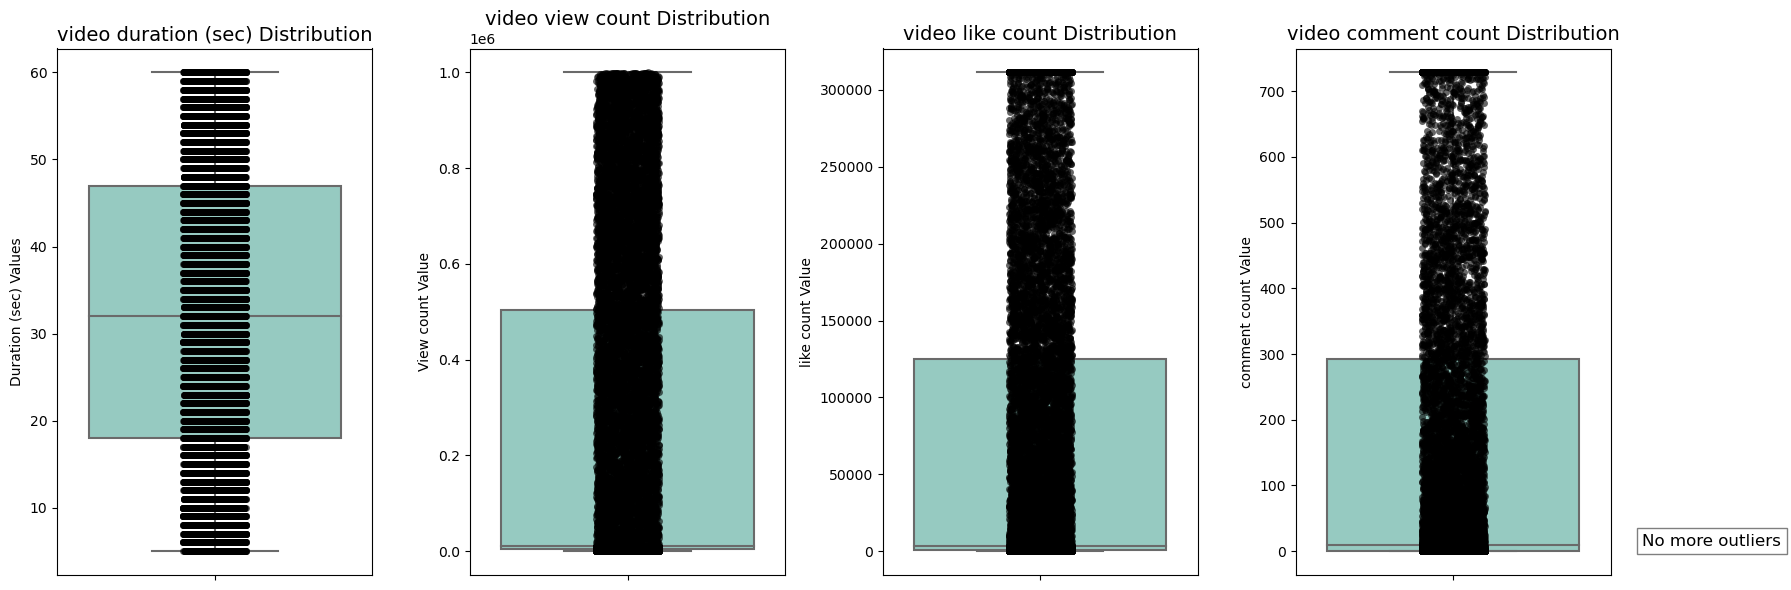

In [219]:
# Create a figure with 4 subplots boxplots (After handling outliers)
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=False)

# video_duration_sec box
sns.boxplot(ax=axes[0], y='video_duration_sec', data=data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[0], y='video_duration_sec', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[0].set_title('video duration (sec) Distribution', fontsize=14)
axes[0].set_ylabel('Duration (sec) Values')

#Add description text
plt.text(0.6, 8, 'No more outliers', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# video_view_count Boxplot 
sns.boxplot(ax=axes[1], y='video_view_count', data= data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[1], y='video_view_count', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[1].set_title('video view count Distribution', fontsize=14)
axes[1].set_ylabel('View count Value')

# video_like_count Boxplot 
sns.boxplot(ax=axes[2], y='video_like_count', data= data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[2], y='video_like_count', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[2].set_title('video like count Distribution', fontsize=14)
axes[2].set_ylabel('like count Value')

# video_comment_count Boxplot 
sns.boxplot(ax=axes[3], y='video_comment_count', data= data, palette='Set3', showmeans=False, showfliers=False)
sns.stripplot(ax=axes[3], y='video_comment_count', data= data, color='black', size=5, jitter=True, marker='o', alpha=0.6)
axes[3].set_title('video comment count Distribution', fontsize=14)
axes[3].set_ylabel('comment count Value')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Resampling data**

In [26]:
# Check total observations in verified status 
data['verified_status']. value_counts(normalize= True)

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64

In [27]:
#Use resampling to create class balance in the outcome variable 
# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

In [30]:
# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

**EDA for video_transcription_text** 

In [36]:
#Create an extra column to get transcript text length for each observations 
data_upsampled['text_length'] = data_upsampled['video_transcription_text'].apply(func = lambda text: len(text))
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


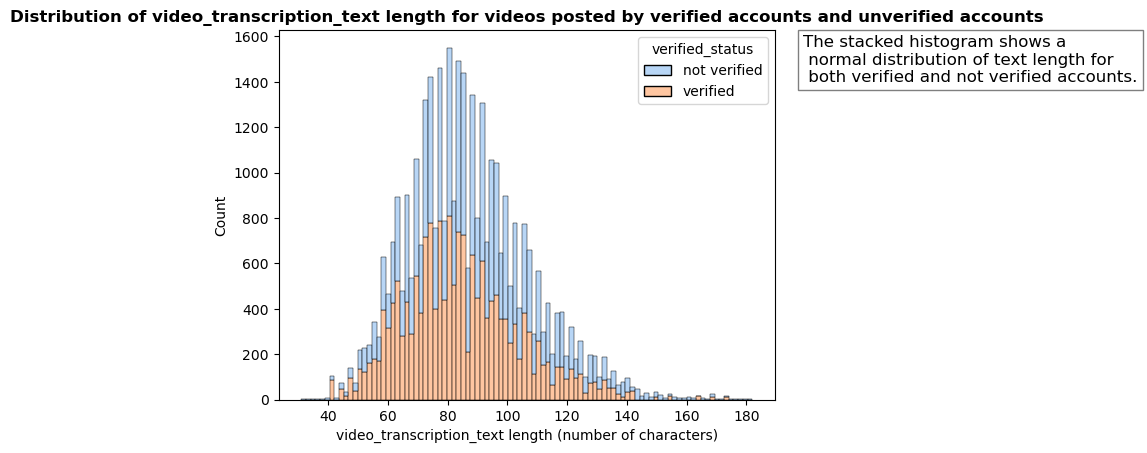

In [61]:
#Visualization distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
sns.histplot(data= data_upsampled, x='text_length', hue= 'verified_status', stat= 'count', multiple= 'stack', palette= 'pastel')

plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and unverified accounts", weight = 'bold')

#Add description text
plt.text(199, 1400, 'The stacked histogram shows a\n normal distribution of text length for \n both verified and not verified accounts.', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

**Check for multicollinearity assumption**

Text(9.5, 2, 'We have strong correlation between\nview count and like count (0.89).\n like count also strongly correlated with\n share, download, comment. Therefore, \nI decide to drop the like count metric. ')

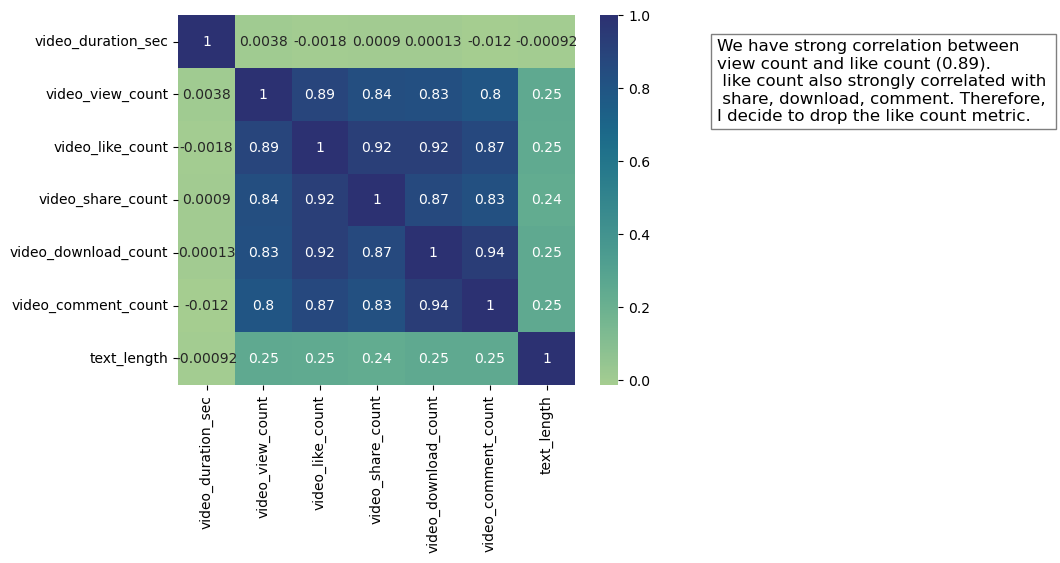

In [78]:
#Create a correlation heatmap 
sns.heatmap(data= data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]].corr(numeric_only= True, method = 'spearman'),
                    annot= True, cmap= 'crest')

#Add description text
plt.text(9.5, 2, 'We have strong correlation between\nview count and like count (0.89).\n like count also strongly correlated with\n share, download, comment. Therefore, \nI decide to drop the like count metric. ', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))


### Construct the binary logistics model 

#### Preprocessing data

In [138]:
#First, I set the X and Y variables 
y = data_upsampled['verified_status']

X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]

**Split data for training and testing**

In [146]:
# Import packages for data modeling
from sklearn.model_selection import train_test_split

#Split the data to training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 0)

In [122]:
X_train.head(3)

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,opinion,active,2252.0,23.0,4.0,0.0
20491,52,opinion,active,6664.0,550.0,53.0,2.0
25583,37,opinion,active,6327.0,257.0,3.0,0.0


In [88]:
# Get shape of each training and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

**Encode categorical variables for training data**

In [92]:
#Check data types 
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [151]:
#See unique values in claim status and author ban status 
print('claim status: ',X_train['claim_status'].unique())
print('author ban status: ', X_train['author_ban_status'].unique())

claim status:  ['opinion' 'claim']
author ban status:  ['active' 'under review' 'banned']


In [152]:
#Encode the claim status and author ban status 
X_train_encoded = OneHotEncoder(drop= 'first', sparse_output= False).fit_transform(X_train[["claim_status", "author_ban_status"]])
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [153]:
# Place encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns= [['claim_status_opinion', 'author_ban_status_banned', 'author_ban_status_under review']])

X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [154]:
# Display first few rows of `X_train` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_train.drop(["claim_status", "author_ban_status"], axis= 1, inplace= True )
X_train.reset_index(drop= True, inplace= True)
X_train.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
0,33,2252.0,23.0,4.0,0.0
1,52,6664.0,550.0,53.0,2.0
2,37,6327.0,257.0,3.0,0.0
3,57,1702.0,28.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0


In [155]:
#Combine the X_train and X_train_encoded_df
X_train_final = pd.concat([X_train, X_train_encoded_df], axis=1)
X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,"(claim_status_opinion,)","(author_ban_status_banned,)","(author_ban_status_under review,)"
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


In [156]:
#Check for any nulls
X_train_final.isna().sum()

video_duration_sec                   0
video_view_count                     0
video_share_count                    0
video_download_count                 0
video_comment_count                  0
(claim_status_opinion,)              0
(author_ban_status_banned,)          0
(author_ban_status_under review,)    0
dtype: int64

In [157]:
#Encode the y dependent variable 
y_train.dtype

dtype('O')

In [158]:
#y dependent variable unique values 
y_train.unique()

array(['verified', 'not verified'], dtype=object)

In [170]:
#Encode y dependent variable 
y_train_final = OneHotEncoder(drop= 'first', sparse_output= False).fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

**Encode categorical variables for testing data**

In [179]:
#Encode the claim status and author ban status 
X_test_encoded = OneHotEncoder(drop= 'first', sparse_output= False).fit_transform(X_test[["claim_status", "author_ban_status"]])
X_test_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [180]:
# Place encoded testing features (which is currently an array) into a dataframe
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns= [['claim_status_opinion', 'author_ban_status_banned', 'author_ban_status_under review']])

X_test_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [181]:
# Display first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_test.drop(["claim_status", "author_ban_status"], axis= 1, inplace= True )
X_test.reset_index(drop= True, inplace= True)
X_test.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
0,41,2118.0,57.0,5.0,2.0
1,27,5701.0,157.0,1.0,0.0
2,31,449767.0,75385.0,5956.0,728.5
3,19,792813.0,56597.0,5146.0,728.5
4,54,2044.0,68.0,19.0,2.0


In [182]:
#Combine the X_test and X_test_encoded_df
X_test_final = pd.concat([X_test, X_test_encoded_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,"(claim_status_opinion,)","(author_ban_status_banned,)","(author_ban_status_under review,)"
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


In [184]:
#Encode y dependent variable 
y_test_final = OneHotEncoder(drop= 'first', sparse_output= False).fit_transform(y_test.values.reshape(-1, 1)).ravel()
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

#### Build the model

In [183]:
#Ensure all columns name in X_train_final and X_test_final are string type
X_train_final.columns = X_train_final.columns.map(str)
X_test_final.columns = X_test_final.columns.map(str)

In [185]:
#See shape of test and train data X and Y 
X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape

((26826, 8), (26826,), (8942, 8), (8942,))

In [176]:
#Construct the logistics model and fit to the training dataset 
log_clf = LogisticRegression(random_state= 0, max_iter= 800).fit(X_train_final, y_train_final)

In [177]:
#Get model coefficients and intercept
#Get the parameters
print('coefficient: ', log_clf.coef_)
print('Intercept: ', log_clf.intercept_)

coefficient:  [[ 8.60789293e-03 -2.13207898e-06  5.93097068e-06 -1.09977533e-05
  -6.40423472e-04  3.90838403e-04 -1.78174065e-05 -9.68244724e-07]]
Intercept:  [0.00029627]


**Predict on test data**

In [186]:
#Use the logistics regression model to predict on the testing set 
y_pred = log_clf.predict(X_test_final)
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

In [187]:
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

#### Evaluate model results

**Evaluation metrics**

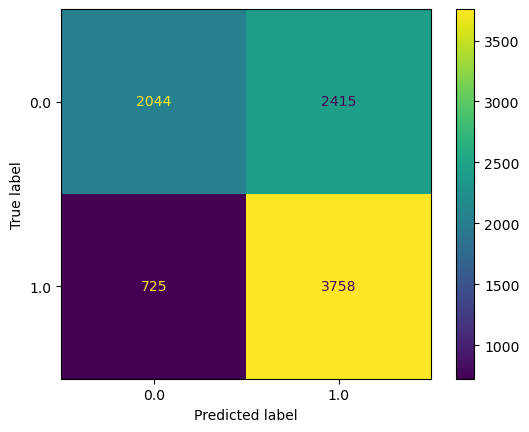

In [192]:
#Visualize the model results 
#Compute values 
cm = confusion_matrix(y_test_final, y_pred, labels= log_clf.classes_)

#Display the confusion matrix 
ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= log_clf.classes_).plot()



In [194]:
#Create a metrics report for the classification model 
target_labels = ['verified', 'not verified']
print(classification_report(y_test_final, y_pred, target_names= target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.46      0.57      4459
not verified       0.61      0.84      0.71      4483

    accuracy                           0.65      8942
   macro avg       0.67      0.65      0.64      8942
weighted avg       0.67      0.65      0.64      8942



The classification report above shows that the logistic regression model achieved a precision of 61% and a recall of 84%, and it achieved an accuracy of 65%. Note that the precision and recall scores are taken from the "not verified" row of the output because that is the target class that we are most interested in predicting. The "verified" class has its own precision/recall metrics, and the weighted average represents the combined metrics for both classes of the target variable.

-For the "not verified" class, the model's precision is 61%, meaning it correctly predicts 61% of the cases labeled as "not verified."

-For the "not verified" class, the recall is 84%, meaning the model successfully identified 84% of the actual "not verified" cases.

-The "not verified" class has an F1-Score of 0.71, indicating better performance in detecting this category.

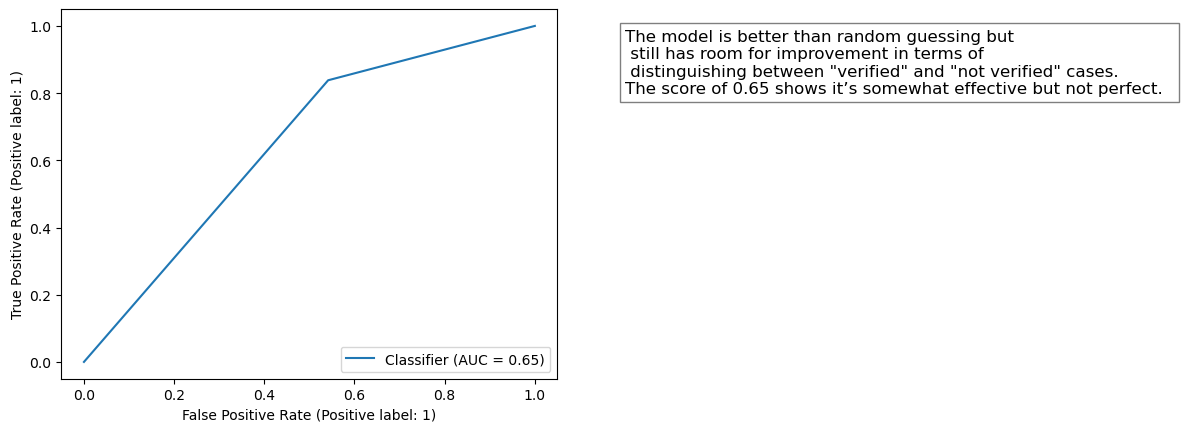

In [207]:
#Create a ROC curve 
RocCurveDisplay.from_predictions(y_test_final, y_pred)

#Add description text
plt.text(1.2, 0.8, 'The model is better than random guessing but\n still has room for improvement in terms of\n distinguishing between "verified" and "not verified" cases. \nThe score of 0.65 shows it’s somewhat effective but not perfect.  ', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

**Interpret model coefficients**

In [218]:
# Set float format to display 8 decimals
pd.options.display.float_format = '{:.8f}'.format

#Display the coefficients
pd.DataFrame(data= log_clf.coef_, columns= log_clf.feature_names_in_).stack()

0  video_duration_sec                     0.00860789
   video_view_count                      -0.00000213
   video_share_count                      0.00000593
   video_download_count                  -0.00001100
   video_comment_count                   -0.00064042
   ('claim_status_opinion',)              0.00039084
   ('author_ban_status_banned',)         -0.00001782
   ('author_ban_status_under review',)   -0.00000097
dtype: float64

Based on the logistic regression model, each additional second of the video is associated with 0.009 increase in the log-odds of the user having a verified status. In other words, If i exponentiate e^0.009 = 1.009, then for each additional second of video duration, the odds of being verified increase by about 0.9%.